In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sns.set_theme(style='whitegrid', font_scale=1.5, palette='muted', rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 16

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time',
                   'model_size [MB]', 'memory [MB]', 'parameters']

def manage_model_name(name: str) -> str:
    spl = name.split('/')
    if len(spl) == 2:
        return spl[1]
    else:
        return name

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_name'] = df['model_name'].apply(lambda x: manage_model_name(x))
    
    df['model_size [MB]'] = df['model_size']/MB
    df['memory [MB]'] = df['memory']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):
        
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.02)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [MB]', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Memory [MB]', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Parameters', title = 'Parameters', ax=ax6)
    
    fig.suptitle(suptitle)
#     fig.tight_layout()   
#     file_name = suptitle.replace(':', '').replace(' ','-') + '.pdf'
#     fig.savefig(file_name, bbox_inches='tight')


def visualize_models_comparision(df: pd.DataFrame, reference_model: str, models: List[str], suptitle: str = ''):
    cols = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision',
     'training_time_in_minutes', 'eval_time',
        'model_size [MB]', 'memory [MB]', 'parameters']
    
    df = df[df['model_name'].isin(models + [reference_model])].copy()[cols]
    values_for_ref = {c: df[df['model_name'] == reference_model][c].values[0] for c in df.columns}
    
    measures = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision']
    for measure in measures:    
        df[measure + '_diff'] = df[measure].apply(lambda x: x - values_for_ref[measure])
        
    for time_measure in ['training_time_in_minutes', 'eval_time']:    
        df[time_measure + '_speedup'] = df[time_measure].apply(lambda x: values_for_ref[time_measure] / x)
        
    for size_measure in ['model_size [MB]', 'memory [MB]', 'parameters']:    
        df[size_measure + '_compression'] = df[size_measure].apply(lambda x: values_for_ref[size_measure] / x)

#     display(df)
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['model_name']   
    measures_to_plot = [m + '_diff' for m in measures]
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
        
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize() for col in measures_to_plot]
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0", data=df_measures, ax=ax1)
    
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Parameters', ax=ax6)
    
    fig.suptitle(suptitle)

     
def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None):
    ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)                     # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar
    
def print_model_comparison(df: pd.DataFrame, original_model: str, distilled_model: str):
    results = defaultdict(dict)
    
    for model in [original_model, distilled_model]:
        for col in df.columns:
            value = df[df['model_name']==model][col].values[0]
            results[model][col] = value
            
    title_1 = "Comparison between:"
    title_2 = f"\n - teacher: {original_model.upper()}\n - student: {distilled_model.upper()}\n"
    seperator = "#"*(int(3*len(title_1)))
    
    text = seperator + "\n" + title_1 + title_2
    
    training_time_gain = results[original_model]['training_time_in_minutes'] / results[distilled_model]['training_time_in_minutes']
    text += f"\nTraining time speedup: {training_time_gain:.1f}x faster"
    
    eval_time_gain = results[original_model]['eval_time'] / results[distilled_model]['eval_time']
    text += f"\nEval time speedup: {eval_time_gain:.1f}x faster"
    
    size_gain = results[original_model]['model_size'] / results[distilled_model]['model_size']
    text += f"\nModel size reduction: {size_gain:.1f}x smaller"
    
    quality_retain = results[distilled_model]['macro avg_f1-score'] / results[original_model]['macro avg_f1-score']
    text += f"\nQuality: {100*quality_retain:.1f}% of teacher's performance"
    text += "\n" + seperator 
    
    fig, ax = plt.subplots()
    ax.set_axis_off()    
    ax.text(0.25, 1, text, bbox={'facecolor':'w','pad': 5}, ha="left", va="top", transform=ax.transAxes, fontsize=16)

# Multiemo EN - All sentences

In [5]:
file_name = 'new_results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

with pd.option_context('display.max_columns', None):
    display(df)

,name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,do_lower_case,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes
0,multiemo_en_all_sentence-run-5,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,828.889559,0.758573,6.850113,0.604990,0.427313,0.500861,681,0.770192,0.813000,0.791017,2123,0.773632,0.817346,0.794888,1522,0.775265,0.773080,0.774171,1419,0.731020,0.707685,0.715234,5745,0.752774,0.758573,0.753487,5745,267866225,267826192,66956548,255.457139,255.418961,13.814826
1,multiemo_en_all_sentence-run-3,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,836.503601,0.758921,6.840242,0.566781,0.486050,0.523320,681,0.787684,0.807348,0.797395,2123,0.795109,0.790407,0.792751,1522,0.755435,0.783650,0.769284,1419,0.726252,0.716864,0.720688,5745,0.755500,0.758921,0.756733,5745,267866225,267826192,66956548,255.457139,255.418961,13.941727
2,multiemo_en_all_sentence-run-1,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,831.260106,0.760139,6.889694,0.620042,0.436123,0.512069,681,0.748545,0.848328,0.795319,2123,0.782076,0.796978,0.789457,1522,0.806723,0.744186,0.774194,1419,0.739346,0.706404,0.717760,5745,0.756566,0.760139,0.754972,5745,267866225,267826192,66956548,255.457139,255.418961,13.854335
3,multiemo_en_all_sentence-run-4,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,835.789006,0.755614,6.846271,0.556719,0.468429,0.508772,681,0.770861,0.822421,0.795807,2123,0.784974,0.796321,0.790607,1522,0.780631,0.749824,0.764917,1419,0.723296,0.709249,0.715026,5745,0.751629,0.755614,0.752775,5745,267866225,267826192,66956548,255.457139,255.418961,13.929817
4,multiemo_en_all_sentence-run-6,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,False,827.753918,0.759791,6.866543,0.616183,0.436123,0.510748,681,0.747408,0.848799,0.794883,2123,0.798286,0.795664,0.796973,1522,0.790262,0.743481,0.766158,1419,0.738035,0.706017,0.717191,5745,0.755917,0.759791,0.754661,5745,267866225,267826192,66956548,255.457139,255.418961,13.795899
5,multiemo_en_all_sentence-run-2,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,831.915137,0.761010,6.863073,0.583181,0.468429,0.519544,681,0.777087,0.824305,0.800000,2123,0.808684,0.783180,0.795728,1522,0.754755,0.782946,0.768592,1419,0.730927,0.714715,0.720966,5745,0.756957,0.761010,0.757866,5745,267866225,267826192,66956548,255.457139,255.418961,13.865252
6,multiemo_en_all_sentence-run-7,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,839.422403,0.775457,6.934964,0.575296,0.499266,0.534591,681,0.768553,0.863401,0.813221,2123,0.836237,0.788436,0.811633,1522,0.811094,0.762509,0.786052,1419,0.747795,0.728403,0.736374,5745,0.774084,0.775457,0.773061,5745,267866225,267826192,66956548,255.457139,255.418961,13.990373
7,multiemo_en_all_sentence-run-5,bert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,1531.680951,0.769887,13.606973,0.587361,0.464023,0.518458,681,0.771899,0.838436,0.803793,2123,0.812000,0.800263,0.806089,1522,0.791577,0.781536,0.786525,1419,0.740709,0.721065,0.728716,5745,0.765509,0.769887,0.766313,5745,438025389,437945360,109485316,417.733563,417.657242,25.528016
8,multiemo_en_all_sentence-run-3,bert-base-uncased,multiemo_en_all_sentence,4,16,0.00002,0.01,0,128,False,1527.818685,0.773368,13.751158,0.592527,0.488987,0.535800,681,0.785873,0.833255,0.808871,2123,0.81404

In [14]:
df[df['do_lower_case'] == True]

,name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,do_lower_case,...,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes
6,multiemo_en_all_sentence-run-7,distilbert-base-uncased,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,...,0.774084,0.775457,0.773061,5745,267866225,267826192,66956548,255.457139,255.418961,13.990373
11,multiemo_en_all_sentence-run-8,bert-base-uncased,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,...,0.785512,0.790078,0.786699,5745,438025389,437945360,109485316,417.733563,417.657242,25.621925
21,multiemo_en_all_sentence-run-7,xtremedistil-l6-h256-uncased,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,...,0.762154,0.767624,0.763039,5745,51049901,51008528,12751108,48.684979,48.645523,6.421255
28,multiemo_en_all_sentence-run-7,TinyBERT_General_4L_312D,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,...,0.759450,0.762924,0.756147,5745,57437831,57410096,14351500,54.776984,54.750534,4.719904
35,multiemo_en_all_sentence-run-7,TinyBERT_General_6L_768D,multiemo_en_all_sentence,4,16,0.00005,0.01,0,128,True,...,0.779463,0.783812,0.780956,5745,267877805,267836432,66958084,255.468183,255.428726,14.113664


In [13]:
cols_to_display2 = ['model_name', 'learning_rate', 'do_lower_case', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time']
df[cols_to_display2].groupby(['model_name', 'learning_rate', 'do_lower_case']).min()

accuracy  \
model_name                   learning_rate do_lower_case             
TinyBERT_General_4L_312D     0.00002       False          0.729156   
                             0.00005       False          0.734726   
                                           True           0.762924   
TinyBERT_General_6L_768D     0.00002       False          0.752829   
                             0.00005       False          0.757180   
                                           True           0.783812   
bert-base-uncased            0.00002       False          0.767624   
                             0.00005       False          0.766754   
                                           True           0.790078   
distilbert-base-uncased      0.00002       False          0.755614   
                             0.00005       False          0.759791   
                                           True           0.775457   
xtremedistil-l6-h256-uncased 0.00002       False          0.732985   
                             0.00005       False          0.748129   
                                           True           0.767624   

                                                          macro avg_f1-score  \
model_name                   learning_rate do_lower_case                       
TinyBERT_General_4L_312D     0.00002       False                    0.685962   
                             0.00005       False                    0.690666   
                                           True                     0.716319   
TinyBERT_General_6L_768D     0.00002       False                    0.712746   
                             0.00005       False                    0.711302   
                                           True                     0.743247   
bert-base-uncased            0.00002       False                    0.717564   
                             0.00005       False                    0.719353   
                                           True                     0.749704   
distilbert-base-uncased      0.00002       False                    0.715026   
                             0.00005       False                    0.717191   
                                           True                     0.736374   
xtremedistil-l6-h256-uncased 0.00002       False                    0.688921   
                             0.00005       False                    0.704160   
                                           True                     0.724627   

                                                          macro avg_recall  \
model_name                   learning_rate do_lower_case                     
TinyBERT_General_4L_312D     0.00002       False                  0.677004   
                             0.00005       False                  0.678295   
                                           True                   0.703512   
TinyBERT_General_6L_768D     0.00002       False                  0.705612   
                             0.00005       False                  0.703245   
                                           True                   0.738118   
bert-base-uncased            0.00002       False                  0.702762   
                             0.00005       False                  0.702746   
                                           True                   0.744687   
distilbert-base-uncased      0.00002       False                  0.706404   
                             0.00005       False                  0.706017   
                                           True                   0.728403   
xtremedistil-l6-h256-uncased 0.00002       False                  0.679233   
                             0.00005       False                  0.693870   
                                           True                   0.717839   

                                                          macro avg_precision  \
model_name                   learning_rate do_lower_case                        
TinyBERT_General_

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      5 non-null      object 
 1   model_name                5 non-null      object 
 2   task_name                 5 non-null      object 
 3   epochs                    5 non-null      int64  
 4   batch_size                5 non-null      int64  
 5   learning_rate             5 non-null      float64
 6   weight_decay              5 non-null      float64
 7   warmup_steps              5 non-null      int64  
 8   max_seq_length            5 non-null      int64  
 9   do_lower_case             5 non-null      bool   
 10  training_time             5 non-null      float64
 11  accuracy                  5 non-null      float64
 12  eval_time                 5 non-null      float64
 13  z_amb_precision           5 non-null      float64
 14  z_amb_recall  

In [9]:
df['model_name'].values

array(['distilbert-base-uncased', 'bert-base-uncased',
       'xtremedistil-l6-h256-uncased', 'TinyBERT_General_4L_312D',
       'TinyBERT_General_6L_768D'], dtype=object)

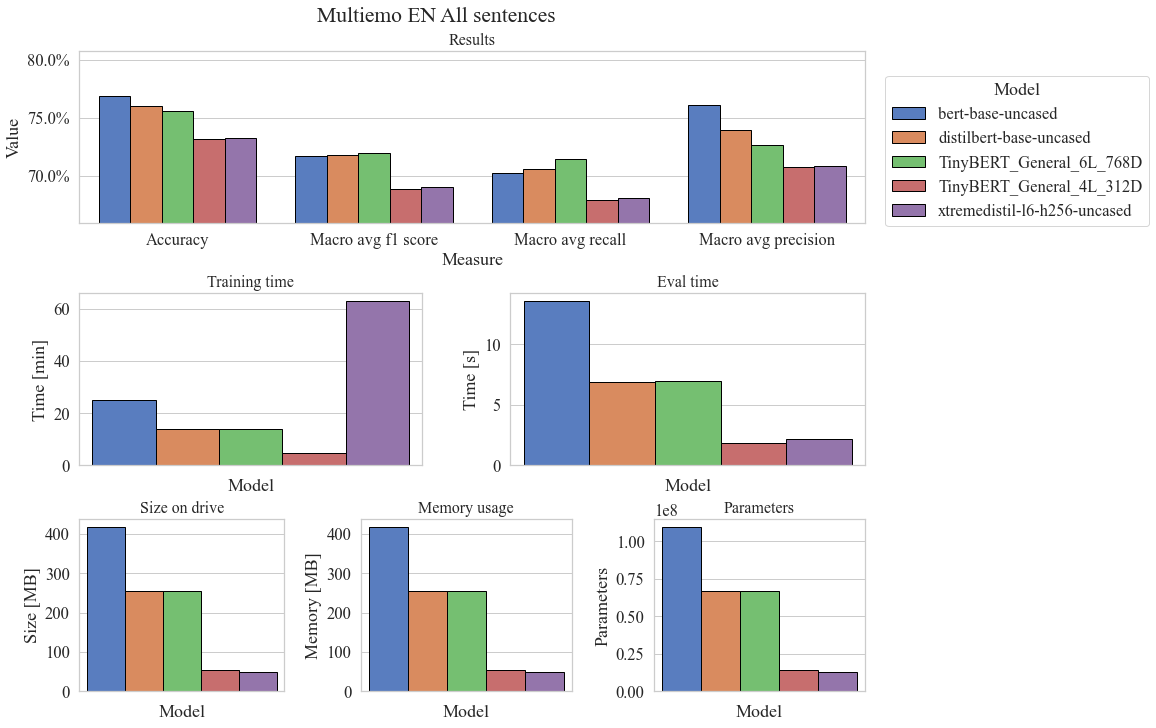

In [12]:
models = ['bert-base-uncased', 'distilbert-base-uncased','TinyBERT_General_6L_768D',
          'TinyBERT_General_4L_312D','xtremedistil-l6-h256-uncased']
visualize_models(df, models, suptitle='Multiemo EN All sentences')

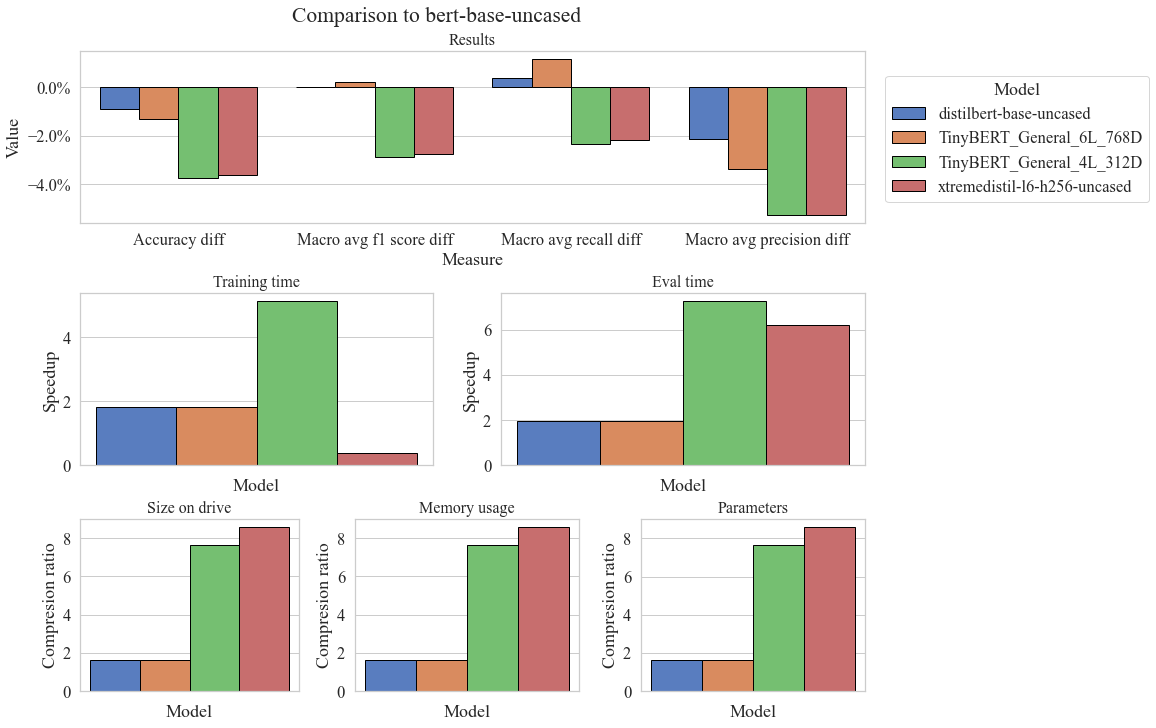

In [13]:
ref_model = 'bert-base-uncased'
models = ['distilbert-base-uncased','TinyBERT_General_6L_768D',
          'TinyBERT_General_4L_312D','xtremedistil-l6-h256-uncased'
         ]
visualize_models_comparision(df, ref_model, models, suptitle='Comparison to {}'.format(ref_model))